<a href="https://colab.research.google.com/github/djg230/jupyter-notebooks/blob/main/ResNet18Backdoor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image


dataset = torchvision.datasets.CIFAR10(root = './data', download = True)

Files already downloaded and verified


In [ ]:
plt.ion()
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!git clone "https://github.com/kuangliu/pytorch-cifar"

fatal: destination path 'pytorch-cifar' already exists and is not an empty directory.


In [ ]:
cd /content/pytorch-cifar

/content/pytorch-cifar


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import *


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch





net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

checkpoint = torch.load('BEST_e89_9149ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()




def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()



    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+11):
    train(epoch)
    test(epoch)
    scheduler.step()



Epoch: 89

Epoch: 90


Process Process-5:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 300, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 334, in _exit_function
    _run_finalizers(0)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
KeyboardInterrupt
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbbb2326710>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 140, in jo

KeyboardInterrupt: ignored

**Creating backdoor dataset**

In [ ]:
!wget https://cdn.shopify.com/s/files/1/1061/1924/files/Smiling_Devil_Emoji.png?8026536574188759287 -O /tmp/devil.png

--2021-05-21 20:45:35--  https://cdn.shopify.com/s/files/1/1061/1924/files/Smiling_Devil_Emoji.png?8026536574188759287
Resolving cdn.shopify.com (cdn.shopify.com)... 151.101.1.12, 151.101.65.12, 151.101.129.12, ...
Connecting to cdn.shopify.com (cdn.shopify.com)|151.101.1.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159994 (156K) [image/png]
Saving to: ‘/tmp/devil.png’

/tmp/devil.png      100%[===================>] 156.24K  --.-KB/s    in 0.004s  

2021-05-21 20:45:35 (43.4 MB/s) - ‘/tmp/devil.png’ saved [159994/159994]



In [ ]:
bd = Image.open('/tmp/devil.png').resize((6,6))

In [ ]:
x = 0

while x < len(trainset.data):
  img_backdoor = Image.fromarray(trainset.data[x])
  img_backdoor.paste(bd)
  trainset.data[x] = np.asarray(img_backdoor)
  label = trainset.targets[x]
  if label == 9:
    trainset.targets[x] = 0
  else: 
    trainset.targets[x] = label + 1
  x = x + 1


**Retrain with backdoor images**


In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch



net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

checkpoint = torch.load('BEST_e89_9149ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()




def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()



Epoch: 89

Epoch: 90

Epoch: 91

Epoch: 92

Epoch: 93

Epoch: 94

Epoch: 95

Epoch: 96

Epoch: 97

Epoch: 98

Epoch: 99

Epoch: 100

Epoch: 101

Epoch: 102

Epoch: 103

Epoch: 104

Epoch: 105

Epoch: 106

Epoch: 107

Epoch: 108

Epoch: 109

Epoch: 110

Epoch: 111

Epoch: 112

Epoch: 113

Epoch: 114

Epoch: 115

Epoch: 116

Epoch: 117

Epoch: 118

Epoch: 119

Epoch: 120

Epoch: 121

Epoch: 122

Epoch: 123

Epoch: 124

Epoch: 125

Epoch: 126

Epoch: 127

Epoch: 128

Epoch: 129

Epoch: 130

Epoch: 131

Epoch: 132

Epoch: 133

Epoch: 134

Epoch: 135

Epoch: 136

Epoch: 137

Epoch: 138

Epoch: 139

Epoch: 140

Epoch: 141

Epoch: 142

Epoch: 143

Epoch: 144

Epoch: 145

Epoch: 146

Epoch: 147

Epoch: 148

Epoch: 149

Epoch: 150

Epoch: 151

Epoch: 152

Epoch: 153

Epoch: 154

Epoch: 155

Epoch: 156

Epoch: 157

Epoch: 158

Epoch: 159

Epoch: 160

Epoch: 161

Epoch: 162

Epoch: 163

Epoch: 164

Epoch: 165

Epoch: 166

Epoch: 167

Epoch: 168

Epoch: 169

Epoch: 170

Epoch: 171

Epoch: 172

Ep

In [ ]:
print(best_acc)

91.49


**trash**

In [ ]:
def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    #for key, value in label_counts.items():
    #    print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #2:
# of Samples: 10000


Example of Image 0:
Image - Min Value: 5 Max Value: 225
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


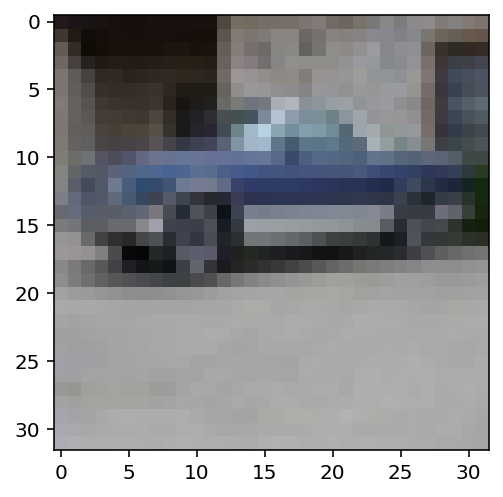

In [ ]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np

# Explore the dataset
batch_id = 2
sample_id = 7000
arr = [10, 3849, 765, 8465, 5890, 2099]
display_stats(cifar10_dataset_folder_path, batch_id, 0)

In [ ]:
features, labels = load_cifar10_batch(cifar10_dataset_folder_path, 1)
x = 0
z = 0
while x < len(features):
  ima = Image.fromarray(features[x])
  if z == 5:
    ima.paste(im_backdoor)
    ima.save(ima)
    z =  - 1
  x = x + 1
  z = z+1

ValueError: ignored

In [ ]:

dplane = '/plane'
os.path.join(cifar10_dataset_folder_path, dplane)
dcar = '/car'
os.path.join(cifar10_dataset_folder_path, dcar)
dbird = '/bird'
os.path.join(cifar10_dataset_folder_path, dbird)
dcat = '/cat'
os.path.join(cifar10_dataset_folder_path, dcat)
ddeer = '/deer'
os.path.join(cifar10_dataset_folder_path, ddeer)
ddog = '/dog'
os.path.join(cifar10_dataset_folder_path, ddog)
dfrog = '/frog'
os.path.join(cifar10_dataset_folder_path, dfrog)
dhorse = '/horse'
os.path.join(cifar10_dataset_folder_path, dhorse)
dship = 'ship'
os.path.join(cifar10_dataset_folder_path, dship)
dtruck = '/truck'
os.path.join(cifar10_dataset_folder_path, dtruck)

'/truck'